In [ ]:
import statistics
import numpy as np
import pandas as pd
import datetime as dt

import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report, roc_curve, RocCurveDisplay

from imblearn.over_sampling import SMOTE
from collections import Counter

from joblib import dump, load

In [ ]:
raw = pd.read_csv('train.csv')

# Logistische Regression

In [ ]:
# Cleaning of missing values
lead = raw.loc[:,:'Datum']
tail = raw.loc[:,'Temperatur':]
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(tail)
tail = pd.DataFrame(imp.transform(tail), columns = tail.columns)
tail = tail.iloc[:14241,:]
raw = pd.concat([lead, tail],axis=1)
raw.drop(['index'], inplace=True, axis=1)

In [ ]:
# Problem für spätere logistische Regression: datetime oder object erzeugt " TypeError: float() argument must be a string or a number, not 'Timestamp' "
# Type Error Lösung: https://stackoverflow.com/questions/16453644/regression-with-date-variable-using-scikit-learn
raw['Datum'] = raw.Datum.astype('datetime64[ns]')

raw['Jahr'] = raw['Datum'].dt.year
raw['Monat'] = raw['Datum'].dt.month
raw['Tag'] = raw['Datum'].dt.day
raw['Stunde'] = raw['Datum'].dt.hour
raw['Minute'] = raw['Datum'].dt.minute
raw['Sekunde'] = raw['Datum'].dt.second
raw['Wochentag'] = raw['Datum'].dt.strftime("%A")

raw.drop(['Datum'], inplace=True, axis=1)

# One Hot Encoding, um kein Object type in den Daten zu haben
Wochentag = pd.get_dummies(raw[['Wochentag']], columns=['Wochentag'])
raw = pd.concat([raw, Wochentag], axis=1) 
raw.drop(['Wochentag'], inplace=True, axis=1)

df = raw.copy()
df.head()

In [ ]:
X = df.drop("Anwesenheit",axis=1).values
y = df["Anwesenheit"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
from sklearn.model_selection import GridSearchCV 

# Hyperparametersuche
logreg = LogisticRegressionCV(cv=5, random_state=42, max_iter=20000)
param_grid = {'penalty':['l1', 'l2', 'elasticnet', 'none'], #Default is l2
             'solver' :['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] #Default is lbfgs
             }
scores = ['accuracy', 'precision', 'recall']

gs = GridSearchCV(logreg,
                 param_grid = param_grid,
                 scoring = scores,
                 refit="recall", # needed for multi param search -> we decide on recall, because we have to minimize occasions, where present = 1 prediction = 0
                 return_train_score=True) # includes Train Scores in cv_results_
gs.fit(X_train,y_train)

Ergebnis der CV: 
Bestes Modell ist LogisticRegressionCV(cv=5, max_iter=20000, random_state=42, solver='newton-cg') 
mit Hyperparametern {'penalty': 'l2', 'solver': 'newton-cg'} und einem Recall von 0.7561643835616437

In [ ]:
df = pd.DataFrame(gs.cv_results_)
df

In [ ]:
print(f"Ergebnis der CV: \nBestes Modell ist {gs.best_estimator_} \nmit Hyperparametern {gs.best_params_} und einem Recall von {gs.best_score_}")

In [ ]:
logreg = LogisticRegressionCV(cv=5, random_state=42, max_iter=20000, penalty='l2', solver='newton-cg').fit(X_train, y_train) # Kreuzvalidierung mit 5 folds

y_pred = logreg.predict(X_test)
y_proba = logreg.predict_log_proba(X_test)
logreg.score(X_test, y_test)

In [ ]:
kreuztabelle = pd.crosstab(index=y_pred, columns=y_test, rownames=["predicted"], colnames=["actual"])
TP = kreuztabelle.values[1,1]
FP = kreuztabelle.values[1,0]
FN = kreuztabelle.values[0,1]
TN = kreuztabelle.values[0,0]
kreuztabelle.sort_index(axis=0, ascending=False).sort_index(axis=1, ascending=False)

In [ ]:
precision = TP/(TP+FP)
TPR = TP/(TP+FN) # Recall
accuracy = (TP+TN)/(TP+TN+FN+TN)
F1 = 2*(precision*TPR/(precision+TPR))
FPR = FP/(FP+TN)

# Precision: Welcher Anteil der als 1 klassifizierten Daten ist auch mit 1 gelabelt?
print(f"Precision: {precision}")
# Accuracy: Anteil der korrekten (0 oder 1 Vorhersagen) an allen Vorhersagen
print(f"Accuracy Score: {accuracy}")
# F1:was macht ein gutes Modell aus? Sowohl eine hohe Trefferquote haben als auch präzise
print(f"F1: {F1}")
# Recall: Welchen Anteil der mit 1 gelabelten Daten findet der Klassifikator?
print(f"Recall (TPR): {TPR}")

print(f"FPR: {FPR}")

Precision: 0.8276374442793462

Accuracy Score: 0.5402493133319248

F1: 0.7923186344238975

Recall (TPR): 0.7598908594815825

FPR: 0.054820415879017016


# Support Vector Classifier

In [ ]:
# Einlesen der Daten
df = raw.copy()

# Spalte Index nicht aussagekräftig --> Wird gelöscht
df = df.drop(columns="index")

# Operationen auf Datumsspalte:
# Anlegen der Spalte Tag und Uhrzeit und Löschen von "Datum", da es nicht sinnführend bei Operationen ist
df["Datum"]=pd.to_datetime(df["Datum"])
df["Tag"]=df["Datum"].dt.day.astype(str)
df["Uhrzeit"]=df["Datum"].dt.hour.astype(str)
df_modified = df.drop(columns="Datum",axis=1)

# Skalierung von CO2, da rechtsschiefe Verteilung 
# und von allen anderen, da SVM sensitiv auf Skalierung reagiert
scaler= MinMaxScaler()
df_modified[["Temperatur","Luftfeuchtigkeit","CO2","Wassergehalt","Tag","Uhrzeit"]]=scaler.fit_transform(df_modified[["Temperatur","Luftfeuchtigkeit","CO2","Wassergehalt","Tag","Uhrzeit"]])

# Auffüllen NaN-Werte mit vorherigem Wert in der Spalte (forward fill)
df_modified.fillna(method="ffill", inplace= True)


# Teile Daten in Features und Label auf
X = df_modified.drop(columns=["Anwesenheit"])
y = df_modified[["Anwesenheit"]]

# Wird benötigt, um richtige Shape zu haben für späteres Vorgehen
y = np.ravel(y)


In [ ]:
# Training auf 10 % des Datensatzes, da Laufzeit sonst zu lange
df_sampled = df_modified.sample(frac=0.1)

# Teile Daten in Features und Label auf
X_sampled = df_sampled.drop(columns=["Anwesenheit"],axis=1)
y_sampled = df_sampled[["Anwesenheit"]]

# Wieder in richtige Shape für später bringen
y_sampled = np.ravel(y_sampled)

# Training und Testset der sampled data 
# Auf Trainingsset wird CV und Training angewandt, auf Testset wird dann überprüft
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

In [ ]:
# GridSearch ohne SMOTE zur Bestimmung der Parameter, welche den höchsten Recall vorbringen

# Auswahlmöglichkeit an möglichen Kombinationen der Parameter, blinde Auswahl
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [0.1, 1], "C": [1, 10]},
    {"kernel": ["linear"], "C": [1, 10]},
    {"kernel": ["poly"],"C": [1, 10]}
]

# Nun: GridSearchCV, sucht mittels CV und eben GridSearch die Kombination der Parameter, welche den höchsten Recall vorbringt
# Gehe hauptsächlich auf Recall, da keine MA frieren sollen
clf_sampled = GridSearchCV(SVC(), tuned_parameters, scoring="recall")

# Fitten der SVC auf den Trainingsdaten der sampled data
clf_sampled.fit(X_s_train, y_s_train)

# Ausgabe der Parameter, welche den höchsten Recall erzeugen
best_parameters_sampled = clf_sampled.best_params_
print(best_parameters_sampled)

# Ausgabe des besten Recall-Ergebnisses
best_result = clf_sampled.best_score_
print(best_result)

# Vorhersage auf Testset
y_s_true, y_s_pred = y_s_test, clf_sampled.predict(X_s_test)

# Ausgabe eines Classification Reports, zeigt Performance auf Testset
print(classification_report(y_s_true, y_s_pred))

In [ ]:
# GridSearch mit vorherigem SMOTE
# SMOTE wird angewandt, da eine ungleich große Verteilung der Daten vorliegt
# Habe dreimal so viele Datenpunkte, in welchen Anwesenheit = 0 ist, als Anwesenheit =1
# Deswegen: Auswahl einer Oversampling-Strategie, hierbei Entscheidung für SMOTE anstatt für Verdreifachen der Datenpunkte mit Anwesenheit = 1

# Geht irgendwie nicht, wenn es explizit definiert wird, also Definition im Nachfolgenden
# SMOTE = SMOTE()

# Transformation wird auf Sampled Data angewandt
X_s_train_SMOTE, y_s_train_SMOTE = SMOTE().fit_resample(X_s_train, y_s_train)

# Willkürliche Auswahl an möglichen Kombinationen, wie oben
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [0.1, 1], "C": [1, 10]},
    {"kernel": ["linear"], "C": [1, 10]},
    {"kernel": ["poly"],"C": [1, 10]}
]


# Gehe hauptsächlich auf Recall, da keine MA frieren sollen
# GridSearchCV, um die besten Hyperparameter zu finden, wodurch Recall maximal ist
clf_SMOTE_sampled = GridSearchCV(SVC(), tuned_parameters, scoring="recall")

# Trainiere SVM
clf_SMOTE_sampled.fit(X_s_train_SMOTE, y_s_train_SMOTE)

# Ausgabe der Parameter, mit denen Recall am höchsten ist
best_parameters_sampled_SMOTE = clf_SMOTE_sampled.best_params_
print(best_parameters_sampled_SMOTE)

best_result_SMOTE = clf_SMOTE_sampled.best_score_
print(best_result_SMOTE)

y_s_true_SMOTE, y_s_pred_SMOTE = y_s_test, clf_SMOTE_sampled.predict(X_s_test)
print(classification_report(y_s_true_SMOTE, y_s_pred_SMOTE))

# Mit SMOTE: Bekomme besseres Ergebnis als ohne!
# Resultat: SMOTE muss auf ganzem Datensatz angewandt werden.

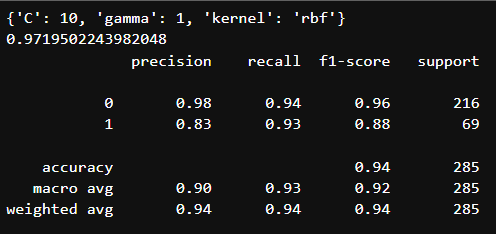

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def data_prep(df_raw):
    
    df_raw = df_raw.drop(columns="index")
    df_raw["Datum"]=pd.to_datetime(df_raw["Datum"])
    df_raw["Tag"]=df_raw["Datum"].dt.day.astype(str)
    df_raw["Uhrzeit"]=df_raw["Datum"].dt.hour.astype(str)
    df_raw = df_raw.drop(columns="Datum",axis=1)
    scaler= MinMaxScaler()
    df_raw[["Temperatur","Luftfeuchtigkeit","CO2","Wassergehalt","Tag","Uhrzeit"]]=scaler.fit_transform(df_raw[["Temperatur","Luftfeuchtigkeit","CO2","Wassergehalt","Tag","Uhrzeit"]])
    df_raw.fillna(method="ffill", inplace= True)
    df_prepared = df_raw
    return df_prepared

df_prepared = data_prep(raw)